In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
import os
import datetime
import numpy as np
import shap

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df = pd.read_csv('./Data/BTC-USDT_Data/BTC-USDT_Data_1m/BTC_USDT_1m_All.csv')
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2017-08-17 13:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7.564907e+03,3,0.075183,3.203909e+02,BTCUSDT
1,2017-08-17 13:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,BTCUSDT
2,2017-08-17 13:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1.117543e+03,2,0.261074,1.117543e+03,BTCUSDT
3,2017-08-17 13:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,5.117185e+01,3,0.012008,5.117185e+01,BTCUSDT
4,2017-08-17 13:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,5.999993e+02,1,0.140796,5.999993e+02,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.694600,3.345834e+06,3245,125.003820,2.073599e+06,BTCUSDT
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.153070,2.275849e+06,3124,66.610050,1.105296e+06,BTCUSDT
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.508600,1.037282e+06,2086,31.996350,5.309577e+05,BTCUSDT
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.594320,7.399709e+05,1529,23.273400,3.861846e+05,BTCUSDT


In [3]:
df['Return'] = df['Close'].pct_change() # Return 계산
df['Maximum Hour Return'] = df['Return'].rolling(window=60).max() # Calculate maximum return
df['Price Volatility'] = df['Close'].rolling(window=60).std() # Minutewise price volatility
df['Return Volatility'] = df['Return'].rolling(window=60).std()  # Minutewise return volatility
for n in [60, 180, 240, 720, 1440]:  # 1, 3, 6, 12, 24 hours *Calculate momentums
    df[f'Momentum {n//60}H'] = df['Close'].pct_change(n)
df['Maximum Daily Return'] = df['Return'].rolling(window=2880).max()
df['Avg Price'] = df['Close'].rolling(window=60).mean() # Calculate average return for 1 hour

In [4]:
df = df.tail(100000)
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Maximum Hour Return,Price Volatility,Return Volatility,Momentum 1H,Momentum 3H,Momentum 4H,Momentum 12H,Momentum 24H,Maximum Daily Return,Avg Price
2717388,2022-10-23 13:20:00,19199.10,19200.05,19198.31,19199.33,31.13612,5.977880e+05,1091,13.94139,2.676654e+05,...,0.000190,4.249780,0.000081,-0.000064,0.001098,-0.000328,-0.000716,0.002669,0.003045,19195.018333
2717389,2022-10-23 13:21:00,19199.31,19204.90,19198.47,19202.57,108.60104,2.085306e+06,2194,60.22025,1.156331e+06,...,0.000190,4.282873,0.000084,0.000062,0.001292,-0.000091,-0.000530,0.002774,0.003045,19195.038333
2717390,2022-10-23 13:22:00,19201.57,19205.11,19201.00,19203.40,88.87642,1.706694e+06,2027,44.40141,8.526561e+05,...,0.000190,4.398378,0.000081,0.000268,0.001362,0.000051,-0.000502,0.002938,0.003045,19195.124167
2717391,2022-10-23 13:23:00,19203.40,19204.42,19199.65,19201.43,54.33883,1.043414e+06,1908,18.70133,3.591085e+05,...,0.000190,4.452930,0.000082,0.000155,0.001339,0.000039,-0.000308,0.002711,0.003045,19195.173667
2717392,2022-10-23 13:24:00,19201.73,19203.21,19200.57,19203.18,23.53928,4.519976e+05,1263,13.64247,2.619630e+05,...,0.000190,4.560884,0.000083,0.000288,0.001280,0.000044,0.000481,0.002527,0.003045,19195.265667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.69460,3.345834e+06,3245,125.00382,2.073599e+06,...,0.000847,13.664047,0.000264,0.000275,0.001428,0.001912,0.001049,0.012363,0.001776,16610.233333
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.15307,2.275849e+06,3124,66.61005,1.105296e+06,...,0.000847,13.659960,0.000262,0.000013,0.001449,0.001979,0.001031,0.012452,0.001776,16610.237000
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.50860,1.037282e+06,2086,31.99635,5.309577e+05,...,0.000847,13.730503,0.000259,-0.000266,0.001457,0.001966,0.001012,0.012104,0.001776,16610.163500
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.59432,7.399709e+05,1529,23.27340,3.861846e+05,...,0.000847,13.838204,0.000260,-0.000403,0.001551,0.001771,0.001091,0.011357,0.001776,16610.052000


In [86]:
19199/0.619018

31015.253191345004

In [5]:
print(df.columns)

Index(['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Symbol', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price'],
      dtype='object')


Text(0, 0.5, 'price')

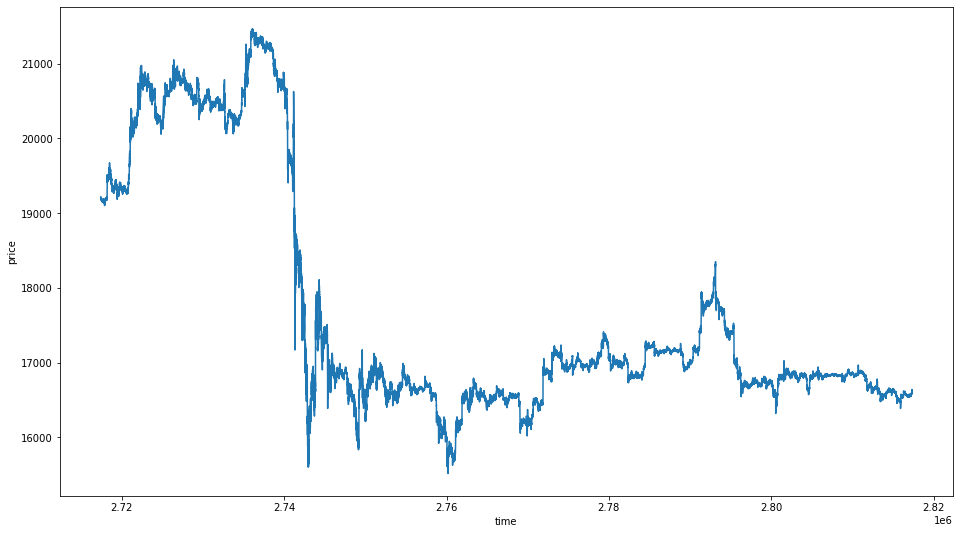

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [7]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)

In [85]:
df

,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Return,Maximum Hour Return,Price Volatility,Return Volatility,Momentum 1H,Momentum 3H,Momentum 4H,Momentum 12H,Momentum 24H,Maximum Daily Return,Avg Price
0,0.619008,0.615814,0.622279,0.619018,0.005648,0.006010,0.009335,0.003902,0.004101,0.341677,0.001886,0.007284,0.003658,0.571149,0.661773,0.561276,0.554566,0.556610,0.046722,0.610206
1,0.619044,0.616631,0.622306,0.619562,0.023085,0.024004,0.025399,0.020147,0.020867,0.343753,0.001886,0.007359,0.003967,0.571963,0.662552,0.562416,0.555352,0.556940,0.046722,0.610210
2,0.619423,0.616666,0.622729,0.619701,0.018645,0.019424,0.022967,0.014594,0.015137,0.341947,0.001886,0.007620,0.003670,0.573293,0.662834,0.563096,0.555474,0.557459,0.046722,0.610224
3,0.619731,0.616550,0.622503,0.619371,0.010871,0.011401,0.021234,0.005573,0.005826,0.339849,0.001886,0.007744,0.003801,0.572559,0.662742,0.563036,0.556295,0.556741,0.046722,0.610233
4,0.619450,0.616346,0.622657,0.619665,0.003939,0.004246,0.011840,0.003797,0.003993,0.342636,0.001886,0.007988,0.003865,0.573417,0.662504,0.563061,0.559648,0.556161,0.046722,0.610249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.179575,0.177139,0.185033,0.181574,0.044039,0.039252,0.040705,0.042886,0.038172,0.351285,0.016262,0.028603,0.024277,0.573339,0.663100,0.572029,0.562057,0.587172,0.018419,0.160537
99996,0.181583,0.177476,0.186135,0.181655,0.029511,0.026309,0.038943,0.022390,0.019904,0.341741,0.016262,0.028594,0.023978,0.571645,0.663188,0.572351,0.561983,0.587455,0.018419,0.160537
99997,0.181663,0.177215,0.186523,0.181604,0.012710,0.011326,0.023826,0.010240,0.009068,0.341065,0.016262,0.028753,0.023726,0.569842,0.663217,0.572290,0.561898,0.586358,0.018419,0.160524
99998,0.181499,0.176984,0.186608,0.181369,0.008678,0.007730,0.015714,0.007178,0.006337,0.340111,0.016262,0.028997,0.023736,0.568955,0.663597,0.571350,0.562235,0.584002,0.018419,0.160505


In [8]:
# 모델 생성 함수

def create_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=8, padding="causal", activation="relu", input_shape=input_shape),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    loss = Huber()
    optimizer = Adam(0.00005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
    return model


In [9]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Parameters
WINDOW_SIZE = 5
BATCH_SIZE = 32


In [11]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df, df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [12]:
# Standardize the data for PCA
scaler_pca = StandardScaler()
scaled_data_pca = scaler_pca.fit_transform(x_train)

In [13]:
# Apply PCA
pca = PCA()
pca.fit(scaled_data_pca)

PCA()

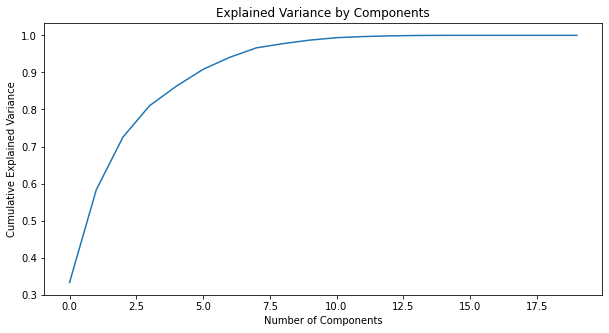

In [14]:
# Visualize explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

In [15]:
# Choose the number of components and transform data
n_components = 10  # You can choose a different number based on the plot
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(scaled_data_pca)
x_test_pca = pca.transform(scaler_pca.transform(x_test))

In [16]:
# Calculate and print the cumulative explained variance
cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance for the first {n_components} components: {cumulative_explained_variance*100:.2f}%")

Cumulative explained variance for the first 10 components: 98.72%


In [17]:
# Get the loading vectors (components)
loading_vectors = pca.components_

# Display the loading vectors for each principal component
for i, loading_vector in enumerate(loading_vectors):
    print(f"Principal Component {i+1}:")
    for feature, coefficient in zip(scale_cols, loading_vector):
        print(f"{feature}: {coefficient:.4f}")
    print()

Principal Component 1:
Open: 0.1701
High: 0.1719
Low: 0.1685
Close: 0.1702
Volume: 0.3461
quote_av: 0.3541
trades: 0.3523
tb_base_av: 0.3446
tb_quote_av: 0.3523
Return: 0.0138
Maximum Hour Return: 0.2364
Price Volatility: 0.2761
Return Volatility: 0.2682
Momentum 1H: -0.0336
Momentum 3H: -0.0572
Momentum 4H: -0.0589
Momentum 12H: -0.0584
Momentum 24H: -0.0899
Maximum Daily Return: 0.1383
Avg Price: 0.1712

Principal Component 2:
Open: -0.3912
High: -0.3902
Low: -0.3921
Close: -0.3912
Volume: 0.0985
quote_av: 0.0593
trades: 0.0973
tb_base_av: 0.0959
tb_quote_av: 0.0572
Return: -0.0021
Maximum Hour Return: 0.1543
Price Volatility: 0.1337
Return Volatility: 0.1895
Momentum 1H: -0.0713
Momentum 3H: -0.1220
Momentum 4H: -0.1299
Momentum 12H: -0.1509
Momentum 24H: -0.1903
Maximum Daily Return: 0.1669
Avg Price: -0.3892

Principal Component 3:
Open: -0.1059
High: -0.1052
Low: -0.1058
Close: -0.1052
Volume: 0.0993
quote_av: 0.0935
trades: 0.0984
tb_base_av: 0.1116
tb_quote_av: 0.1054
Return: 0

In [18]:
# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Display the explained variance ratio for each principal component
for i, variance_ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {variance_ratio*100:.2f}%")


Principal Component 1: 33.32%
Principal Component 2: 24.99%
Principal Component 3: 14.23%
Principal Component 4: 8.49%
Principal Component 5: 5.25%
Principal Component 6: 4.54%
Principal Component 7: 3.25%
Principal Component 8: 2.56%
Principal Component 9: 1.14%
Principal Component 10: 0.95%


In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
predicted = []


for i in range(1, 11):
    train_data = windowed_dataset(x_train_pca, y_train, WINDOW_SIZE + i - 1, BATCH_SIZE, True)
    model = create_model([WINDOW_SIZE + i - 1, n_components]) # Change input shape to match PCA components
    earlystopping = EarlyStopping(monitor='loss', patience=35)
    filename = os.path.join('tmp', f'ckeckpointer_step_{i}.ckpt')
    checkpoint = ModelCheckpoint(filename, 
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 monitor='loss', 
                                 verbose=1)
    history = model.fit(train_data, epochs=20, callbacks=[checkpoint, earlystopping])
    model.load_weights(filename)
    window = x_train_pca[-(WINDOW_SIZE + i - 1):].reshape(1, WINDOW_SIZE + i - 1, -1)
    pred = model.predict(window)
    predicted.append(pred[0, 0])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/20
   2813/Unknown - 10s 3ms/step - loss: 0.0219 - mse: 0.0439
Epoch 1: loss improved from inf to 0.02193, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0219 - mse: 0.0439
Epoch 2/20
2807/2813 [============================>.] - ETA: 0s - loss: 7.6616e-04 - mse: 0.0015
Epoch 2: loss improved from 0.02193 to 0.00076, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 8s 3ms/step - loss: 7.6480e-04 - mse: 0.0015
Epoch 3/20
2797/2813 [============================>.] - ETA: 0s - loss: 3.6112e-04 - mse: 7.2225e-04
Epoch 3: loss improved from 0.00076 to 0.00036, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 8s 3ms/step - loss: 3.5928e-04 - 

In [21]:
print(f"Predicted values: {predicted}")
print(f"Actual values: {y_test[:10].values}")
print(f"MSE: {mean_squared_error(y_test[:10].values, predicted)}")

Predicted values: [0.22133793, 0.22120231, 0.22099626, 0.22176304, 0.221848, 0.22182764, 0.22257392, 0.22106732, 0.2216194, 0.22149882]
Actual values: [0.2215403  0.22188294 0.22176705 0.22196692 0.22181408 0.22204418
 0.22204418 0.22152183 0.22140257 0.22159405]
MSE: 1.731203943046871e-07


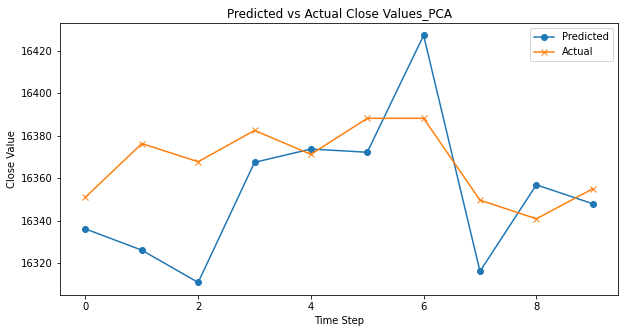

In [89]:
import matplotlib.pyplot as plt

# predicted와 y_test[:5]를 73806으로 곱함
predicted_scaled = [p * 73806 for p in predicted[:10]]
actual_scaled = [a * 73806 for a in y_test[:10].values]

# 그래프를 그림
plt.figure(figsize=(10, 5))
plt.plot(predicted_scaled, label="Predicted", marker='o')
plt.plot(actual_scaled, label="Actual", marker='x')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.title('Predicted vs Actual Close Values_PCA')
plt.show()

In [88]:
16586/6970 * 31016

73806.51018651362

# Bollinger

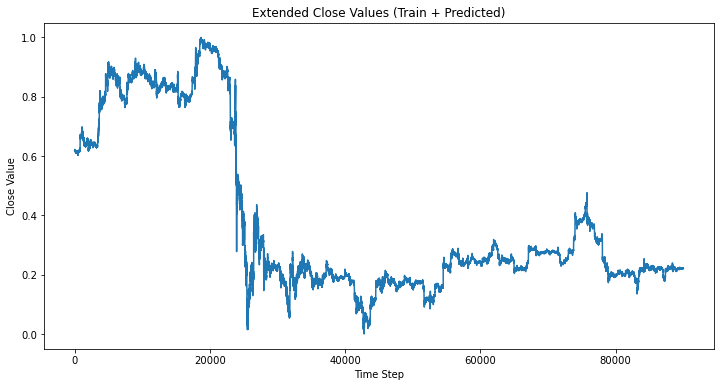

Buy Signals: [89962, 89964, 89965, 89987, 89988, 89989, 89990, 89991, 90002, 90007]
Sell Signals: [89982, 89983, 89984, 89985, 89996, 89997, 90003, 90004, 90005, 90006]
Profit: 90.70779675621839


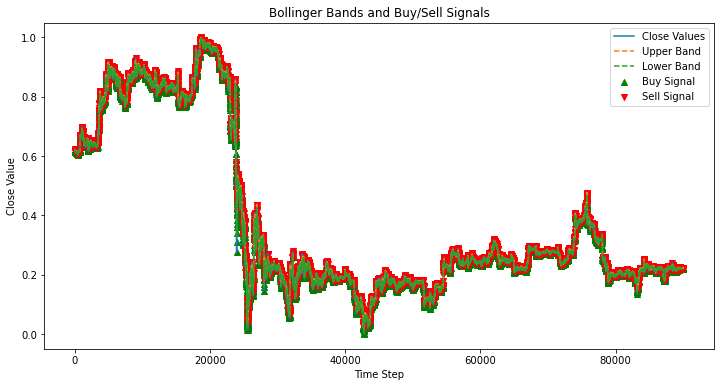

In [82]:
import numpy as np

# Append predicted close values to train close values
extended_close_values = np.concatenate((x_train['Close'].values, predicted))

# Plot the extended close values
plt.figure(figsize=(12, 6))
plt.plot(extended_close_values)
plt.title('Extended Close Values (Train + Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.show()

# Calculate the Bollinger Bands
window_size = 10
ma = pd.Series(extended_close_values).rolling(window=window_size).mean()
std = pd.Series(extended_close_values).rolling(window=window_size).std()
upper_band = ma + 0.8*std
lower_band = ma - 0.8*std

# Generate buy and sell signals
buy_signals = []
sell_signals = []
for i in range(window_size, len(extended_close_values)):
    if extended_close_values[i] < lower_band[i]:
        buy_signals.append(i)
    elif extended_close_values[i] > upper_band[i]:
        sell_signals.append(i)

# Calculate the profit/loss from the buy and sell signals
profit = 0
for i in range(len(buy_signals) - 1):
    buy_price = extended_close_values[buy_signals[i]]
    sell_price = extended_close_values[sell_signals[i]]
    profit += sell_price - buy_price

# Display the signals and profit
print('Buy Signals:', buy_signals[-10:])
print('Sell Signals:', sell_signals[-10:])
print('Profit:', profit)

# Display the Bollinger Bands and signals
plt.figure(figsize=(12, 6))
plt.plot(extended_close_values, label='Close Values')
plt.plot(upper_band, label='Upper Band', linestyle='--')
plt.plot(lower_band, label='Lower Band', linestyle='--')
plt.scatter(buy_signals, [extended_close_values[i] for i in buy_signals], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals, [extended_close_values[i] for i in sell_signals], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Bollinger Bands and Buy/Sell Signals')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.show()


In [90]:
# Multiply all values by 73806
scaled_extended_close_values = extended_close_values * 73806
scaled_upper_band = upper_band * 73806
scaled_lower_band = lower_band * 73806

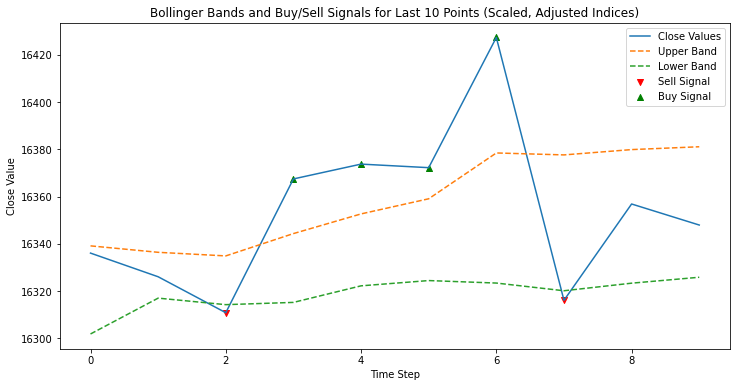

In [91]:
# Adjust the indices for the upper and lower bands to align with the last 10 data points
adjusted_upper_band = scaled_upper_band[-10:].reset_index(drop=True)
adjusted_lower_band = scaled_lower_band[-10:].reset_index(drop=True)

# Adjust the indices for the buy and sell signals
adjusted_buy_signals = [i - len(scaled_extended_close_values) + 10 for i in buy_signals if i >= len(scaled_extended_close_values) - 10]
adjusted_sell_signals = [i - len(scaled_extended_close_values) + 10 for i in sell_signals if i >= len(scaled_extended_close_values) - 10]

# Display the last 10 data points with adjusted indices
plt.figure(figsize=(12, 6))
plt.plot(scaled_extended_close_values[-10:], label='Close Values')
plt.plot(adjusted_upper_band, label='Upper Band', linestyle='--')
plt.plot(adjusted_lower_band, label='Lower Band', linestyle='--')

# Change the labels and colors for buy and sell signals
plt.scatter(adjusted_buy_signals, [scaled_extended_close_values[i] for i in buy_signals if i >= len(scaled_extended_close_values) - 10], 
            marker='v', color='r', label='Sell Signal', alpha=1)
plt.scatter(adjusted_sell_signals, [scaled_extended_close_values[i] for i in sell_signals if i >= len(scaled_extended_close_values) - 10], 
            marker='^', color='g', label='Buy Signal', alpha=1)

plt.title('Bollinger Bands and Buy/Sell Signals for Last 10 Points (Scaled, Adjusted Indices)')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.show()


In [92]:
# Initialize variables to keep track of capital and positions
capital = 100000  # Initial capital (you can set this to your starting capital)
position = 0  # The current position (0 means no position, 1 means long, -1 means short)
btc_qty = 1  # Number of bitcoins to buy/sell

# Iterate through the last 10 data points
for i in range(-10, 0):
    close_value = scaled_extended_close_values[i]
    upper_value = scaled_upper_band[i + 10] # Adjusted index
    lower_value = scaled_lower_band[i + 10] # Adjusted index
    
    # Check for buy signal
    if close_value > upper_value and position == 0:
        capital -= close_value * btc_qty
        position = 1
    
    # Check for sell signal
    elif close_value < lower_value and position == 0:
        capital += close_value * btc_qty
        position = -1
        
    # Check for position closure for long
    elif position == 1 and close_value < upper_value:
        capital += close_value * btc_qty
        position = 0
        
    # Check for position closure for short
    elif position == -1 and close_value > lower_value:
        capital -= close_value * btc_qty
        position = 0

# Calculate the returns
returns = (capital - 100000) / 100000 * 100

print(f'The returns from the last 10 time steps is {returns}%')


The returns from the last 10 time steps is 16.3479417026639%


In [93]:
from math import sqrt

In [96]:
# Calculate RMSE for PCA
predicted_scaled_ary = np.array([p * 73806 for p in predicted[:10]])
actual_scaled_ary = np.array([a * 73806 for a in y_test[:10].values])
rmse_pca = sqrt(mean_squared_error(predicted_scaled_ary, actual_scaled_ary))
print('RMSE for PCA:', rmse_pca)

RMSE for PCA: 30.709007831747876


In [97]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Convert the lists to arrays
predicted_scaled_ary = np.array([p * 73806 for p in predicted[:10]])
actual_scaled_ary = np.array([a * 73806 for a in y_test[:10].values])

# Calculate MAE
mae = mean_absolute_error(actual_scaled_ary, predicted_scaled_ary)
print('MAE:', mae)

# Calculate SMAPE
smape_numerator = np.abs(predicted_scaled_ary - actual_scaled_ary)
smape_denominator = (np.abs(actual_scaled_ary) + np.abs(predicted_scaled_ary)) / 2
smape = 100 * np.mean(smape_numerator / smape_denominator)
print('SMAPE:', smape)


MAE: 25.12666217432197
SMAPE: 0.15360761637905793
